In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import clustering_utils
import math
from itertools import combinations
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster import cluster_visualizer

In [2]:
def get_element_cluster(element, clusters):
    for (index, list_of_elements) in enumerate(clusters):
        if element in list_of_elements:
            return index

def plot_clusters_compositions(users_df, clusters, plot_title = None):
    labels = [
        get_element_cluster(index, clusters)
        for index in range(len(users_df))
    ]

    bot_xt_pct = pd.crosstab(labels, users_df['bot'])
    bot_xt_pct.plot(
        kind='bar', 
        stacked=False, 
        log=True,
        title=plot_title,
        ylabel="Number of users"
    )
    
def visualize_clusters_entropy(clusters_ids: list, clusters_entropy: list, plot_title = None):
    """
    Plots the entropy of the clusters
    
    :param clusters_ids: list of int, the ids of the clusters to study
    :param clusters_entropy: list of float, the value of entropy for each cluster; i.e. the i-th element of this list
        contains the entropy of the i-th cluster
    """
    x = np.arange(len(clusters_ids))
    
    fig, ax = plt.subplots()
    plt.bar(x=x, height=clusters_entropy)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Entropy')
    ax.set_title(plot_title)
    ax.set_xticks(x, clusters_ids)
    
    plt.show()
    
def apply_correlation_threshold(df: pd.DataFrame, correlation_method: str, threshold: float) -> pd.DataFrame:
    # Create correlation matrix
    corr_matrix = df.corr(numeric_only=True).abs()

    # Select upper triangle of correlation matrix (correlation matrix is symmetrical)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than the threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # Drop features 
    return df.drop(to_drop, axis=1)

def plot_clusters_sizes(clusters, plot_title=None):
    _, ax = plt.subplots()
    
    ax.set_title(plot_title)
    ax.set_ylabel("Number of users")
    
    clusters_id = []
    clusters_size = []
    for cluster_id, cluster_elements in enumerate(clusters):
        clusters_id.append(cluster_id)
        clusters_size.append(len(cluster_elements))
    
    ax.bar(x=clusters_id, height=clusters_size, log=True)
    
compute_entropy = lambda p: -(p*math.log(p) + (1-p)*math.log(1-p)) if p != 1 and p != 0 else 0

def get_element_cluster(element, clusters):
    for (index, list_of_elements) in enumerate(clusters):
        if element in list_of_elements:
            return index

def compute_clusters_composition(users_df, clusters):
    clusters_composition = []
    for cluster_id, cluster_indexes in enumerate(clusters):
        real_users = []
        bot_users = []
        for user_index in cluster_indexes:
            if users_df.iloc[user_index]["bot"] == 1:
                bot_users.append(user_index)
            else:
                real_users.append(user_index)
        clusters_composition.append((real_users, bot_users))
    return clusters_composition

In [3]:
users_df = pd.read_csv("dataset/users_df_dataset_cleaned_with_indicators.csv")
users_df.dropna(inplace=True)
users_df.info(verbose=True)
users_df.describe()

# dropping non numeric columns 
users_df.drop(columns=["name", "lang", "created_at", "day_with_most_tweets"], inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11108 entries, 0 to 11108
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   user_id                                   11108 non-null  int64  
 1   name                                      11108 non-null  object 
 2   lang                                      11108 non-null  object 
 3   bot                                       11108 non-null  int64  
 4   created_at                                11108 non-null  object 
 5   statuses_count                            11108 non-null  int64  
 6   account_age_in_days                       11108 non-null  int64  
 7   number_of_tweets                          11108 non-null  int64  
 8   account_average_tweets_per_day            11108 non-null  float64
 9   avg_tweets_per_actual_day                 11108 non-null  float64
 10  day_with_most_tweets              

# Apply correlations threshold

In [4]:
users_df.corr(numeric_only=True)

,user_id,bot,statuses_count,account_age_in_days,number_of_tweets,account_average_tweets_per_day,avg_tweets_per_actual_day,max_number_of_tweets_in_a_day,entropy_for_day,entropy_for_hour,...,total_retweet_count,account_discussion_creation_ratio,tweet_num_likes_ratio,tweet_num_replies_ratio,entropy_original_text,entropy_text,mean_inactive_period_length_in_seconds,median_inactive_period_length_in_seconds,mode_inactive_period_length_in_seconds,mode_count
user_id,1.000000,0.108663,-0.128434,-0.906211,-0.364519,0.001973,-0.041710,-0.128582,0.032830,0.404907,...,-0.025607,0.056235,0.033828,-0.093658,-0.225183,-0.225401,-0.133454,-0.084186,-0.054146,-0.256874
bot,0.108663,1.000000,-0.295653,-0.204438,-0.301675,-0.290326,-0.145907,-0.220276,-0.336429,-0.244810,...,-0.190769,0.117694,0.064896,0.041525,-0.361151,0.327010,0.049125,0.043598,0.027286,-0.235706
statuses_count,-0.128434,-0.295653,1.000000,0.160216,0.326484,0.939768,-0.007206,0.115349,0.283189,0.068783,...,0.094913,-0.060292,-0.000853,-0.023175,0.387708,-0.036353,-0.054211,-0.033850,-0.020024,0.247151
account_age_in_days,-0.906211,-0.204438,0.160216,1.000000,0.381948,0.015118,0.056379,0.134946,0.091367,-0.232126,...,0.026813,-0.058179,-0.016332,0.059498,0.300411,0.124809,0.153118,0.092391,0.063290,0.262156
number_of_tweets,-0.364519,-0.301675,0.326484,0.381948,1.000000,0.319150,0.497080,0.654847,0.773373,0.434503,...,0.253791,0.123639,0.070362,-0.027845,0.852005,0.448554,-0.114393,-0.068527,-0.040161,0.817640
account_average_tweets_per_day,0.001973,-0.290326,0.939768,0.015118,0.319150,1.000000,0.014536,0.146155,0.307830,0.111875,...,0.120774,-0.058717,-0.013667,-0.028166,0.373560,-0.037581,-0.054608,-0.033459,-0.019749,0.244627
avg_tweets_per_actual_day,-0.041710,-0.145907,-0.007206,0.056379,0.497080,0.014536,1.000000,0.765602,0.301208,0.429363,...,0.133263,0.332290,0.094386,0.022285,0.346077,0.180878,-0.047341,-0.028388,-0.016691,0.600329
max_number_of_tweets_in_a_day,-0.128582,-0.220276,0.115349,0.134946,0.654847,0.146155,0.765602,1.000000,0.522477,0.485938,...,0.266846,0.122748,0.040022,-0.003415,0.584219,0.184049,-0.083342,-0.050768,-0.029800,0.656887
entropy_for_day,0.032830,-0.336429,0.283189,0.091367,0.773373,0.307830,0.301208,0.522477,1.000000,0.758421,...,0.236180,0.068927,0.071606,-0.098428,0.885377,0.246943,-0.222057,-0.156085,-0.098061,0.598773
entropy_for_hour,0.404907,-0.244810,0.068783,-0.232126,0.434503,0.111875,0.429363,0.485938,0.758421,1.000000,...,0.209806,0.105657,0.095291,-0.080485,0.521530,-0.037377,-0.204232,-0.146944,-0.094063,0.364053


# X-means

X-means wants to resolve three major issues of K-means: K-means scales poorly computationally, the need of supplying the number of clusters K and the fact that the algorithm is prone to local minima.

For instance we cut all the columns with spearman coefficient > 0.7

In [5]:
subset_df = apply_correlation_threshold(users_df, "spearman", 0.7)
subset_df.drop(columns=["user_id", "bot"], inplace=True)

Using the standard scaler on data

In [6]:
scaler = StandardScaler()
scaler.fit(subset_df.values)
transform_result = scaler.fit_transform(subset_df.values)

In [8]:
initial_centers = kmeans_plusplus_initializer(transform_result, 2).initialize()
xmeans_instance = xmeans(transform_result, initial_centers, 40)
xmeans_instance.process()

In [9]:
print(subset_df.columns)
print(initial_centers)

Index(['statuses_count', 'number_of_tweets', 'avg_tweets_per_actual_day',
       'avg_hashtags', 'avg_text_length', 'avg_mentions', 'total_likes',
       'avg_favorite_count', 'total_replies', 'total_retweet_count',
       'account_discussion_creation_ratio', 'tweet_num_likes_ratio',
       'tweet_num_replies_ratio', 'entropy_text',
       'mean_inactive_period_length_in_seconds'],
      dtype='object')
[array([-0.3765486 , -0.76754638, -0.3127069 ,  1.3696985 , -0.07077603,
       -0.72839395, -0.0095939 ,  0.26945594, -0.03136117, -0.1743344 ,
       -0.24103334, -0.37457607, -0.14229947, -0.23696856, -0.08253591]), array([-3.37003740e-01,  2.12264977e+00,  5.76906023e+00, -6.71055367e-01,
       -1.47930724e+00,  1.27900885e+00, -3.27747638e-02, -5.27701858e-02,
       -3.13611650e-02, -1.79494320e-01,  4.28281825e+01,  5.88557497e+00,
       -1.42299468e-01, -1.87115123e-01, -1.56019608e-01])]


In [10]:
clusters = xmeans_instance.get_clusters()

In [11]:
labels = [
    get_element_cluster(index, clusters)
    for index in range(len(users_df))
]

clusters_composition = compute_clusters_composition(users_df, clusters)

## Studying the composition of our clusters 

### Size of clusters

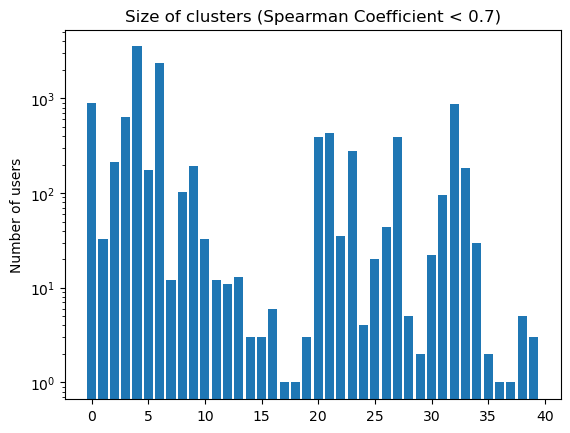

In [12]:
plot_clusters_sizes(clusters, "Size of clusters (Spearman Coefficient < 0.7)")

### Number of real bots and users in the cluster

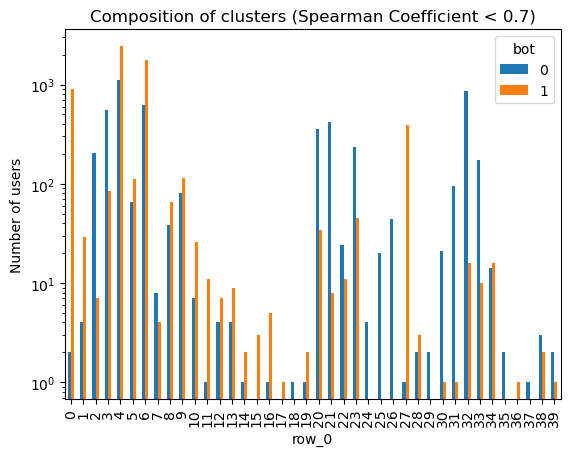

In [13]:
plot_clusters_compositions(users_df, clusters, "Composition of clusters (Spearman Coefficient < 0.7)")

### Entropy for the clusters

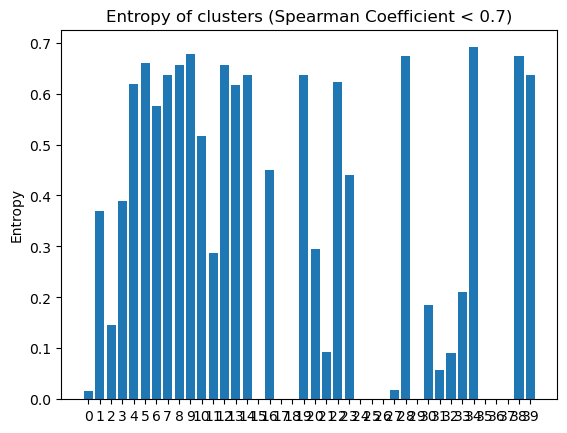

In [14]:
clusters_entropy = []
for real_users, bot_users in clusters_composition:
    number_users_in_cluster = len(real_users)
    number_bots_in_cluster = len(bot_users)
    total_number_of_elements = number_users_in_cluster + number_bots_in_cluster
    frequency_users = number_users_in_cluster / total_number_of_elements
    entropy = compute_entropy(frequency_users)
    clusters_entropy.append(entropy)
    
visualize_clusters_entropy(list(range(len(clusters_entropy))), clusters_entropy, "Entropy of clusters (Spearman Coefficient < 0.7)")

### Computing silhouette score

The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).
The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [15]:
silhouette_score(transform_result, labels)

0.3324326376017834

### Computing WCE 

Computes SSE (Sum of Squared Errors); sum of metric errors is calculated using distance between point and its center.

In [16]:
xmeans_instance.get_total_wce()

29400.351104242625

### Computing Separation

The score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Thus, clusters which are farther apart and less dispersed will result in a better score.

The minimum score is zero, with lower values indicating better clustering.

In [17]:
davies_bouldin_score(transform_result, labels)

0.9436265627176048

# Putting all together

In [18]:
scaler = StandardScaler()
dropped_cols_df = users_df.drop(columns=["user_id", "bot"])
values = dropped_cols_df.values
scaler.fit(values)
transform_result = scaler.fit_transform(values)

In [19]:
scaled_df = pd.DataFrame(transform_result, columns=dropped_cols_df.columns)
scaled_df

,statuses_count,account_age_in_days,number_of_tweets,account_average_tweets_per_day,avg_tweets_per_actual_day,max_number_of_tweets_in_a_day,entropy_for_day,entropy_for_hour,entropy_for_minute,avg_hashtags,...,total_retweet_count,account_discussion_creation_ratio,tweet_num_likes_ratio,tweet_num_replies_ratio,entropy_original_text,entropy_text,mean_inactive_period_length_in_seconds,median_inactive_period_length_in_seconds,mode_inactive_period_length_in_seconds,mode_count
0,-0.330547,-0.925343,-0.679990,-0.301232,-0.229323,-0.388521,0.074575,0.705837,1.252944,-0.228892,...,-0.179493,0.070204,0.168136,-0.142299,-0.331796,-0.265762,-0.132352,-0.088423,-0.051222,-0.561302
1,-0.348302,-0.930747,-0.688329,-0.325729,-0.230025,-0.399892,0.101078,0.815217,1.314947,-0.560221,...,-0.179494,0.236536,0.041744,-0.142299,-0.406787,-0.293059,-0.130503,-0.088424,-0.051222,-0.527864
2,-0.389461,1.587825,-0.781722,-0.384705,-0.299541,-0.559088,-1.229674,-0.991506,-0.145896,-0.671055,...,-0.179495,-0.241050,-0.374775,-0.142299,-2.345835,-0.397043,2.108924,-0.079476,-0.051222,-0.619819
3,-0.351530,0.454647,0.347339,-0.350965,-0.140615,1.032872,0.512716,-0.621158,-0.799510,-0.320761,...,-0.179090,-0.226920,-0.258677,-0.142299,0.911523,1.596132,-0.143766,-0.087508,-0.051222,0.283010
4,5.325982,-1.134323,2.078455,8.315394,0.395096,-0.024644,0.998721,-0.267179,-0.746251,-0.119446,...,-0.179474,0.465860,-0.027440,-0.142299,1.388666,-0.391907,-0.158580,-0.087851,-0.048996,2.063590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11103,0.516842,-1.429778,0.091341,1.215953,-0.044708,-0.001902,1.219525,1.076376,-0.203072,0.246410,...,1.987221,-0.241048,0.002605,-0.142299,0.798652,-0.375685,-0.157362,-0.088376,-0.051222,0.124179
11104,2.048600,-0.381274,0.861837,2.367025,-0.157428,0.430201,0.795518,0.251310,-0.417096,-0.128576,...,0.085192,-0.241019,-0.276281,-0.142299,1.148307,-0.388846,-0.152387,-0.088336,-0.051222,0.700986
11105,-0.387040,1.643673,-0.780054,-0.383112,-0.312707,-0.570459,-1.229674,-0.916326,-0.435271,0.757472,...,-0.179495,-0.241050,-0.374775,-0.142299,-1.937417,-0.402470,3.414092,1.244280,-0.051210,-0.619819
11106,-0.357987,-0.957771,-0.702504,-0.338651,-0.238863,-0.456748,0.126407,0.905246,1.615020,-0.627767,...,-0.179492,-0.066367,-0.137790,-0.142299,-0.475804,-0.292410,-0.128373,-0.088424,-0.051222,-0.561302


In [20]:
subset_df = apply_correlation_threshold(dropped_cols_df, "spearman", 0.3)
scaled_df[subset_df.columns]

,statuses_count,account_age_in_days,avg_hashtags,total_likes,avg_favorite_count,total_replies,total_retweet_count,tweet_num_replies_ratio,mean_inactive_period_length_in_seconds
0,-0.330547,-0.925343,-0.228892,-0.032847,-0.052662,-0.031361,-0.179493,-0.142299,-0.132352
1,-0.348302,-0.930747,-0.560221,-0.032836,-0.052626,-0.031361,-0.179494,-0.142299,-0.130503
2,-0.389461,1.587825,-0.671055,-0.032898,-0.052780,-0.031361,-0.179495,-0.142299,2.108924
3,-0.351530,0.454647,-0.320761,-0.030313,-0.052228,-0.031361,-0.179090,-0.142299,-0.143766
4,5.325982,-1.134323,-0.119446,-0.030713,-0.052596,-0.031361,-0.179474,-0.142299,-0.158580
...,...,...,...,...,...,...,...,...,...
11103,0.516842,-1.429778,0.246410,-0.032282,-0.052610,-0.031361,1.987221,-0.142299,-0.157362
11104,2.048600,-0.381274,-0.128576,-0.028467,-0.052129,-0.031361,0.085192,-0.142299,-0.152387
11105,-0.387040,1.643673,0.757472,-0.032898,-0.052780,-0.031361,-0.179495,-0.142299,3.414092
11106,-0.357987,-0.957771,-0.627767,-0.032806,-0.052510,-0.031361,-0.179492,-0.142299,-0.128373


In [21]:
initial_centers = kmeans_plusplus_initializer(transform_result, 2).initialize()
centroids_df = pd.DataFrame(initial_centers, columns = dropped_cols_df.columns)

centroids_df[subset_df.columns]

,statuses_count,account_age_in_days,avg_hashtags,total_likes,avg_favorite_count,total_replies,total_retweet_count,tweet_num_replies_ratio,mean_inactive_period_length_in_seconds
0,-0.359601,-0.957771,-0.400387,-0.032795,-0.052467,-0.031361,-0.179493,-0.142299,-0.127014
1,-0.369285,1.876073,2.186000,1.355923,33.554191,-0.027976,0.049908,-0.138210,1.936189


In [22]:
# scaling data
scaler = StandardScaler()
dropped_cols_df = users_df.drop(columns=["user_id", "bot"])
scaler.fit(dropped_cols_df.values)
transform_result = scaler.fit_transform(dropped_cols_df.values)

# saving scaled data in a dataframe
scaled_df = pd.DataFrame(transform_result, columns=dropped_cols_df.columns)

# finding random initial centroids
initial_centers = kmeans_plusplus_initializer(transform_result, 2).initialize()
centroids_df = pd.DataFrame(initial_centers, columns = dropped_cols_df.columns)

## Spearman with different thresholds

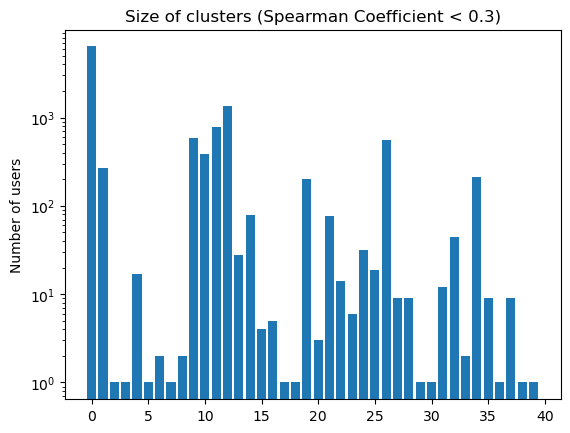

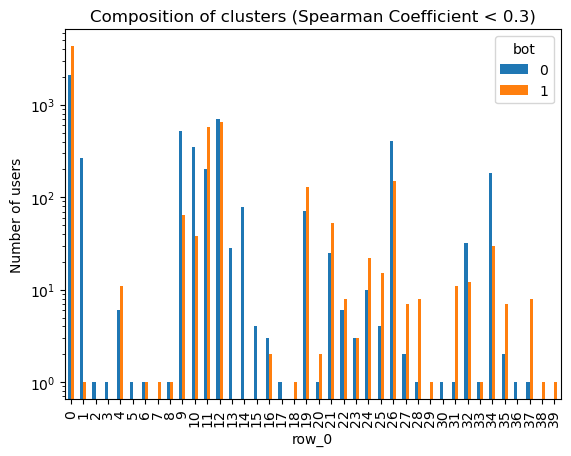

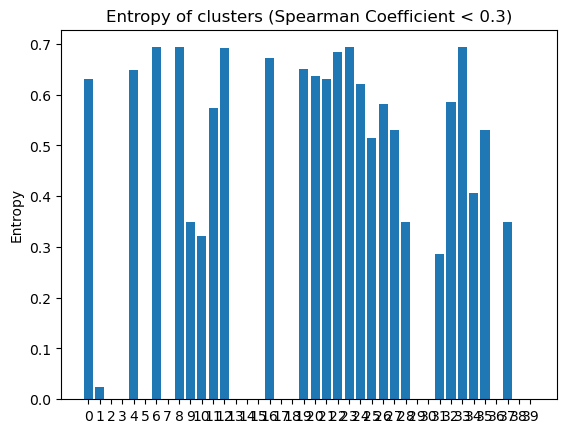

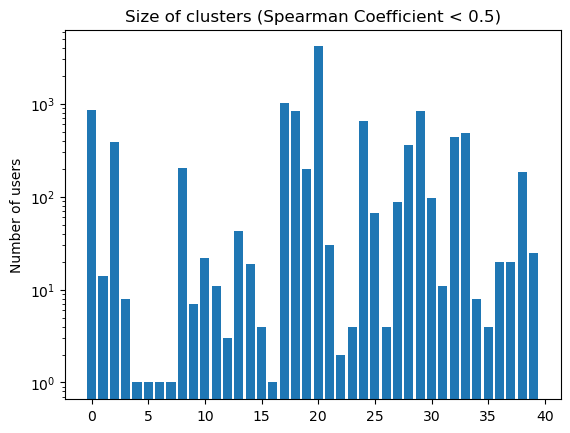

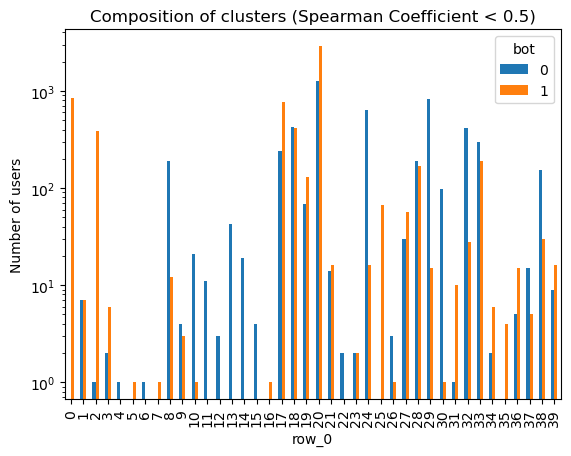

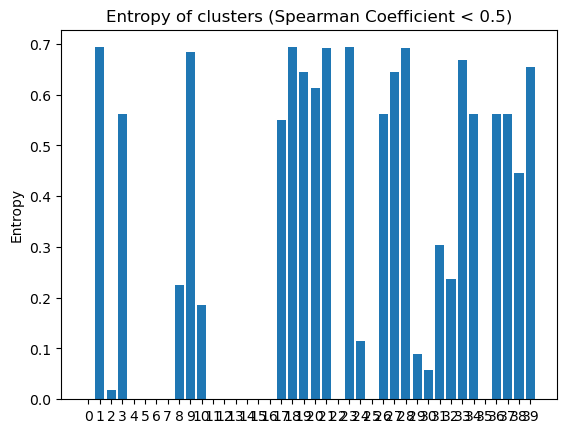

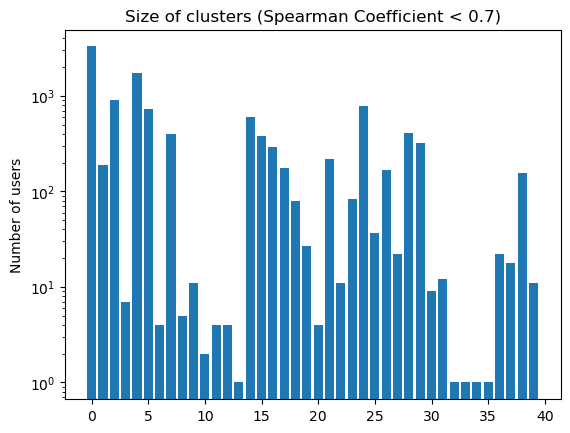

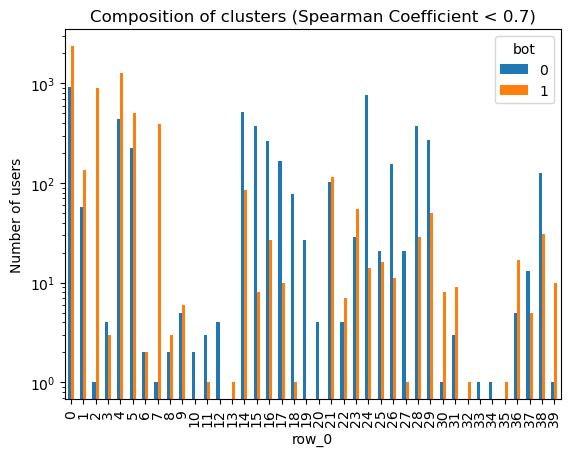

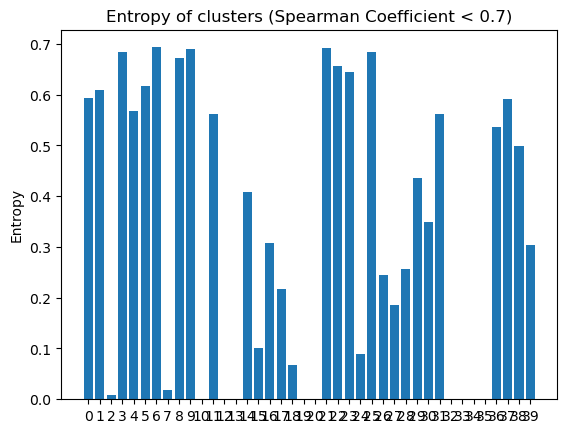

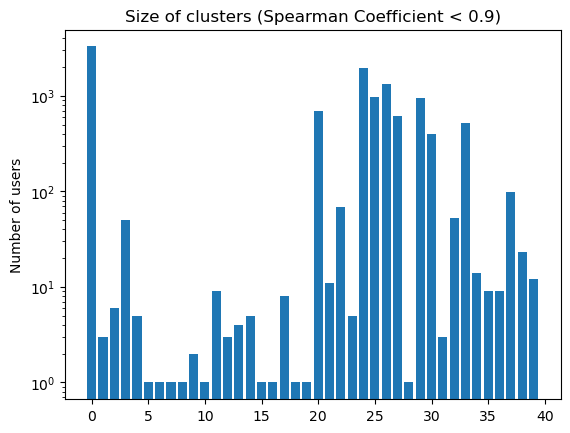

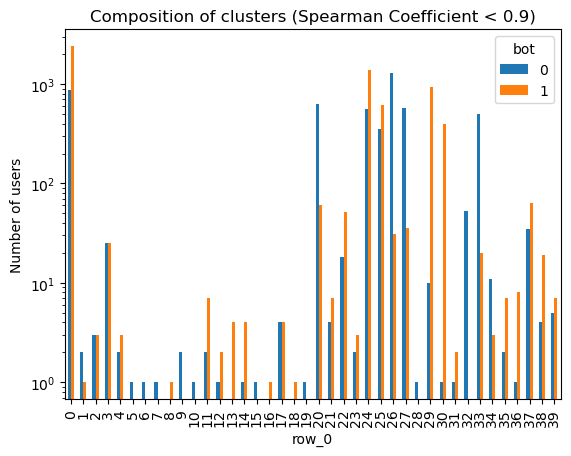

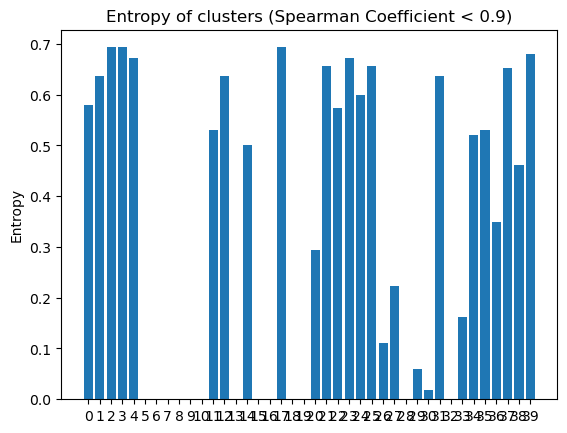

In [23]:
correlation_index = "spearman"

thresholds = [0.3, 0.5, 0.7, 0.9]
metrics_df = pd.DataFrame(
    [
        [None, None, None]
        for threshold in thresholds
    ],
    index= [threshold for threshold in thresholds],
    columns=["Silhouette", "WCE", "Davies Bouldin"]
)

# scaling data
scaler = StandardScaler()
dropped_cols_df = users_df.drop(columns=["user_id", "bot"])
scaler.fit(dropped_cols_df.values)
transform_result = scaler.fit_transform(dropped_cols_df.values)

# saving scaled data in a dataframe
scaled_df = pd.DataFrame(transform_result, columns=dropped_cols_df.columns)

# finding random initial centroids
initial_centers = kmeans_plusplus_initializer(transform_result, 2).initialize()
centroids_df = pd.DataFrame(initial_centers, columns = dropped_cols_df.columns)

for threshold in thresholds:
    subset_df = apply_correlation_threshold(users_df, correlation_index, threshold)
    subset_df.drop(columns=["user_id", "bot"], inplace=True)
    
    # NOTE HERE WE DON'T INIT
    transform_result = scaled_df[subset_df.columns].values 
    initial_centers = centroids_df[subset_df.columns].values 
    
    # using xmeans to find clusters
    xmeans_instance = xmeans(transform_result, initial_centers, 40)
    xmeans_instance.process()
    clusters = xmeans_instance.get_clusters()
    labels = [
        get_element_cluster(index, clusters)
        for index in range(len(users_df))
    ]
 
    # plots the size of each cluster
    plot_clusters_sizes(clusters, f"Size of clusters (Spearman Coefficient < {threshold})")
    
    # plot the composition (bot/non bots) of each cluster
    plot_clusters_compositions(users_df, clusters, f"Composition of clusters (Spearman Coefficient < {threshold})")
    
    # plots the entropy of each cluster
    clusters_composition = compute_clusters_composition(users_df, clusters)
    clusters_entropy = []
    for real_users, bot_users in clusters_composition:
        number_users_in_cluster = len(real_users)
        number_bots_in_cluster = len(bot_users)
        total_number_of_elements = number_users_in_cluster + number_bots_in_cluster
        frequency_users = number_users_in_cluster / total_number_of_elements
        entropy = compute_entropy(frequency_users)
        clusters_entropy.append(entropy)
    visualize_clusters_entropy(list(range(len(clusters_entropy))), clusters_entropy, f"Entropy of clusters (Spearman Coefficient < {threshold})")
    
    # get cluster metrics
    metrics_df.loc[threshold]["Silhouette"] = silhouette_score(transform_result, labels)
    metrics_df.loc[threshold]["WCE"] = xmeans_instance.get_total_wce()
    metrics_df.loc[threshold]["Davies Bouldin"] = davies_bouldin_score(transform_result, labels)

In [24]:
metrics_df

,Silhouette,WCE,Davies Bouldin
0.3,0.477507,5752.899159,0.511641
0.5,0.348005,23322.037925,0.858615
0.7,0.340478,27159.453195,0.935099
0.9,0.414018,51879.036395,0.808946


## Pearson with different thresholds

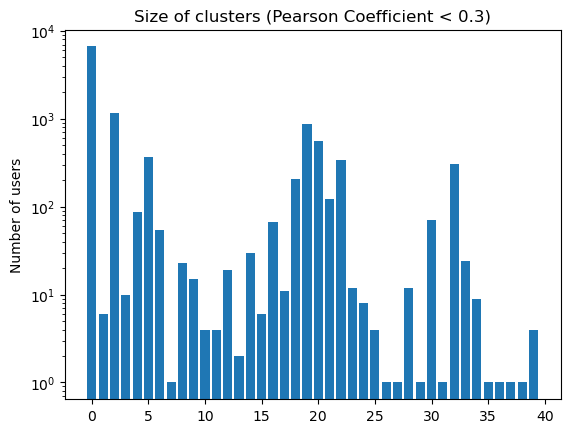

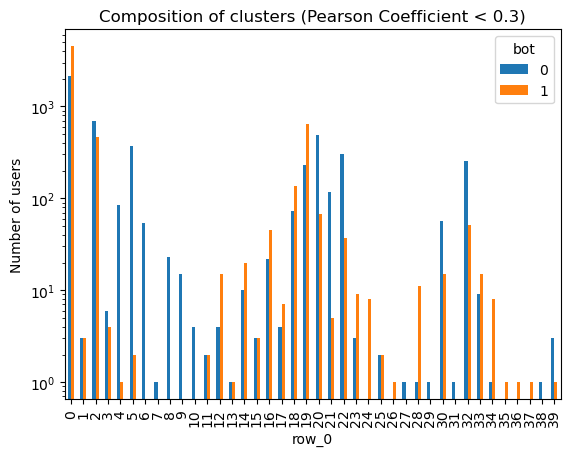

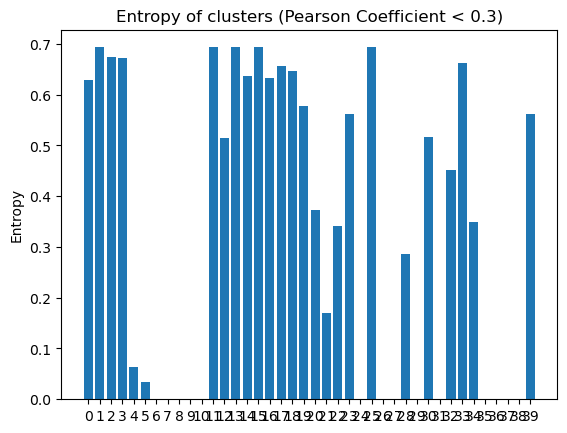

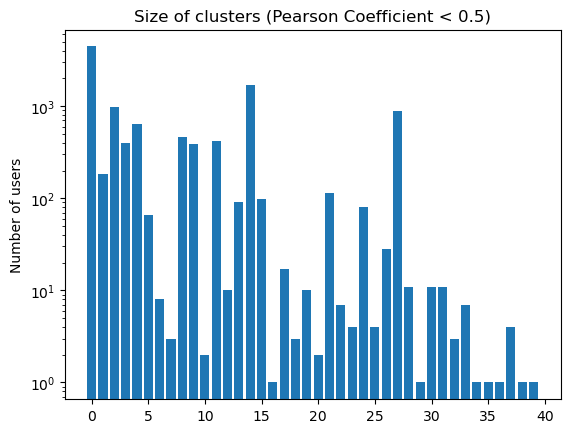

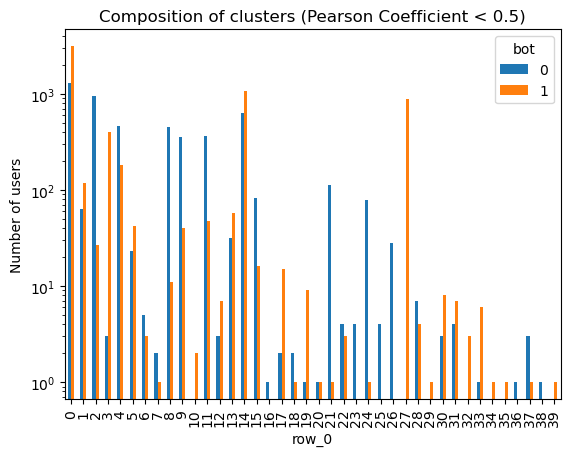

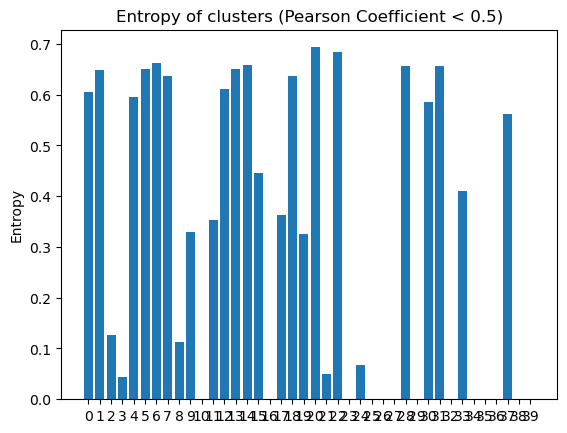

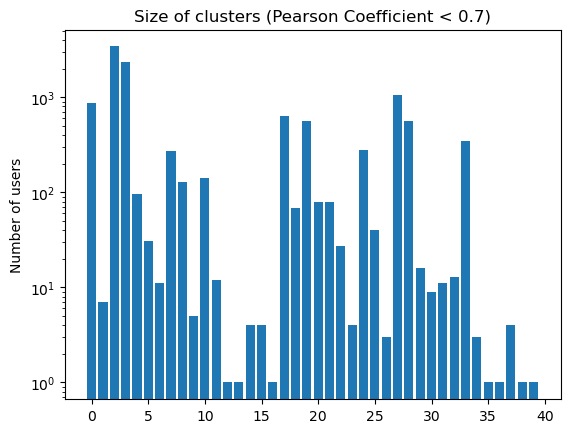

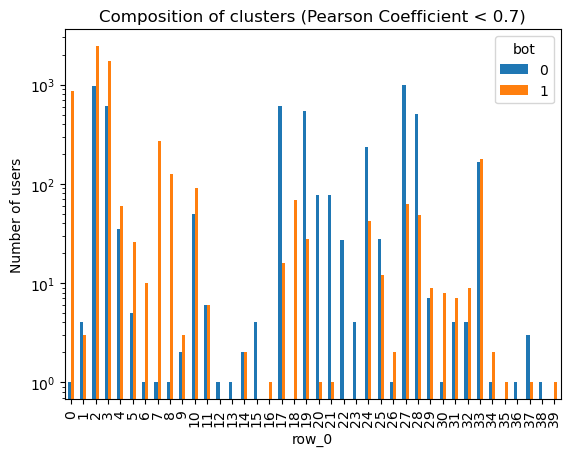

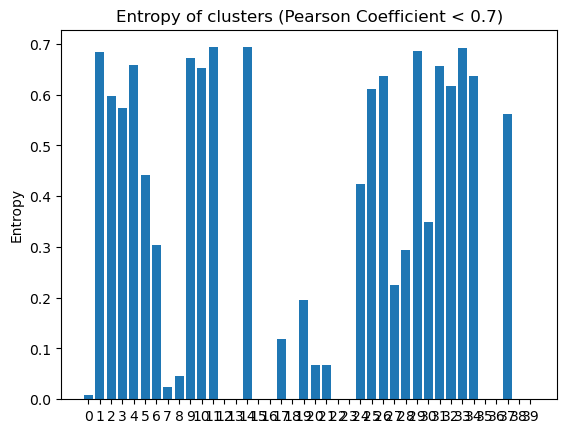

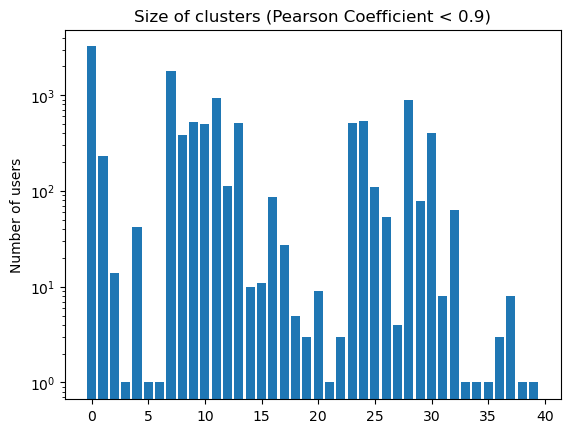

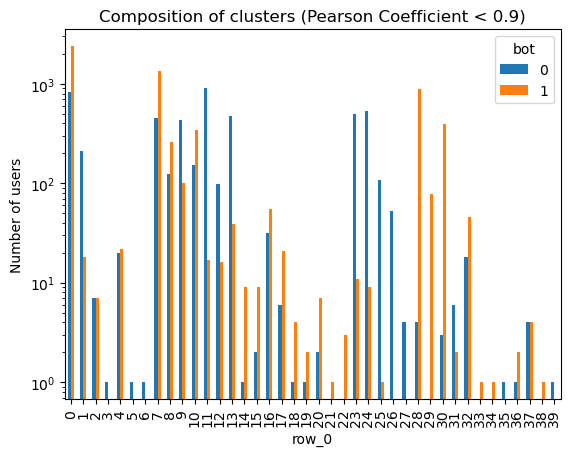

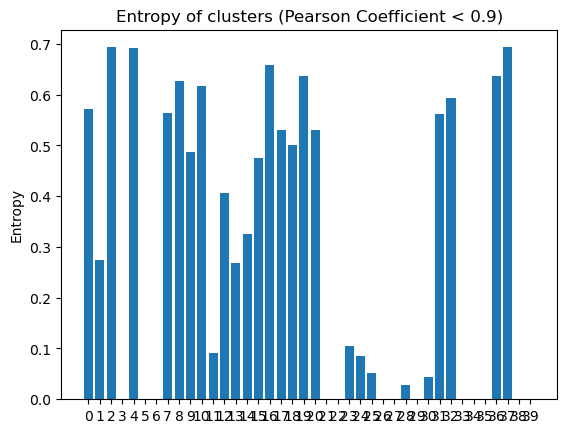

In [25]:
correlation_index = "pearson"

thresholds = [0.3, 0.5, 0.7, 0.9]
metrics_df = pd.DataFrame(
    [
        [None, None, None]
        for threshold in thresholds
    ],
    index= [threshold for threshold in thresholds],
    columns=["Silhouette", "WCE", "Davies Bouldin"]
)

# scaling data
scaler = StandardScaler()
dropped_cols_df = users_df.drop(columns=["user_id", "bot"])
scaler.fit(dropped_cols_df.values)
transform_result = scaler.fit_transform(dropped_cols_df.values)

# saving scaled data in a dataframe
scaled_df = pd.DataFrame(transform_result, columns=dropped_cols_df.columns)

# finding random initial centroids
initial_centers = kmeans_plusplus_initializer(transform_result, 2).initialize()
centroids_df = pd.DataFrame(initial_centers, columns = dropped_cols_df.columns)

for threshold in thresholds:
    subset_df = apply_correlation_threshold(users_df, correlation_index, threshold)
    subset_df.drop(columns=["user_id", "bot"], inplace=True)
    
    # NOTE HERE WE DON'T INIT
    transform_result = scaled_df[subset_df.columns].values 
    initial_centers = centroids_df[subset_df.columns].values 
    
    # using xmeans to find clusters
    xmeans_instance = xmeans(transform_result, initial_centers, 40)
    xmeans_instance.process()
    clusters = xmeans_instance.get_clusters()
    labels = [
        get_element_cluster(index, clusters)
        for index in range(len(users_df))
    ]
 
    # plots the size of each cluster
    plot_clusters_sizes(clusters, f"Size of clusters (Pearson Coefficient < {threshold})")
    
    # plot the composition (bot/non bots) of each cluster
    plot_clusters_compositions(users_df, clusters, f"Composition of clusters (Pearson Coefficient < {threshold})")
    
    # plots the entropy of each cluster
    clusters_composition = compute_clusters_composition(users_df, clusters)
    clusters_entropy = []
    for real_users, bot_users in clusters_composition:
        number_users_in_cluster = len(real_users)
        number_bots_in_cluster = len(bot_users)
        total_number_of_elements = number_users_in_cluster + number_bots_in_cluster
        frequency_users = number_users_in_cluster / total_number_of_elements
        entropy = compute_entropy(frequency_users)
        clusters_entropy.append(entropy)
    visualize_clusters_entropy(list(range(len(clusters_entropy))), clusters_entropy, f"Entropy of clusters (Pearson Coefficient < {threshold})")
    
    # get cluster metrics
    metrics_df.loc[threshold]["Silhouette"] = silhouette_score(transform_result, labels)
    metrics_df.loc[threshold]["WCE"] = xmeans_instance.get_total_wce()
    metrics_df.loc[threshold]["Davies Bouldin"] = davies_bouldin_score(transform_result, labels)

In [26]:
metrics_df

,Silhouette,WCE,Davies Bouldin
0.3,0.509045,5858.45106,0.621095
0.5,0.323265,24710.91901,0.847883
0.7,0.329311,27888.894415,0.824245
0.9,0.41566,48277.229616,0.911849
